In [1]:
import os
import sys 

# Modify the path 
sys.path.append("..")

import numpy as np
import pandas as pd
import yellowbrick as yb
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier

from yellowbrick.classifier import ConfusionMatrix

# Before

Currently, the percents in rows of the `ConfusionMatrix` don't always add up to 100!

In [2]:
occupancy = pd.read_csv('data/occupancy/occupancy.csv')
features = [
    "temperature", "relative humidity", "light", "C02", "humidity"
]
classes = ["unoccupied", "occupied"]
oX = occupancy[features]
oy = occupancy['occupancy']

# Create the train and test data
oX_train, oX_test, oy_train, oy_test = train_test_split(oX, oy, test_size=0.2)

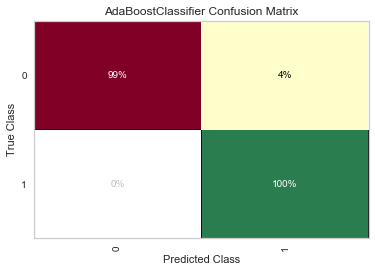

In [3]:
model = AdaBoostClassifier()
cm = ConfusionMatrix(model, percent=True)
cm.fit(oX_train, oy_train)
cm.score(oX_test, oy_test)
cm.show()

In [4]:
# Load multi-class classification dataset
game = pd.read_csv('data/game/game.csv')

classes = ["win", "loss", "draw"]

# Encode the non-numeric columns
game.replace({'loss':-1, 'draw':0, 'win':1, 'x':2, 'o':3, 'b':4}, inplace=True)

# Extract the numpy arrays from the data frame
gX = game.iloc[:, game.columns != 'outcome']
gy = game['outcome']

# Create the train and test data
gX_train, gX_test, gy_train, gy_test = train_test_split(gX, gy, test_size=0.2)

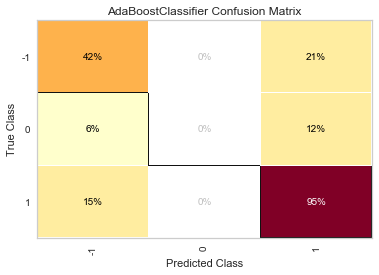

In [5]:
model = AdaBoostClassifier()
cm = ConfusionMatrix(model, percent=True)
cm.fit(gX_train, gy_train)
cm.score(gX_test, gy_test)
cm.show()

In [6]:
np.random.seed(11)
rX = pd.DataFrame(np.random.rand(500,5))
ry = np.random.binomial(1, .6, size=500)

rX_train, rX_test, ry_train, ry_test = train_test_split(rX, ry, test_size = 0.2, random_state=42)

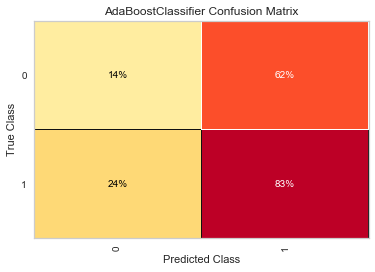

In [7]:
model = AdaBoostClassifier()
cm = ConfusionMatrix(model, percent=True)
cm.fit(rX_train, ry_train)
cm.score(rX_test, ry_test)
cm.show()

In [8]:
##########################################################################
## Imports
##########################################################################

import warnings
import numpy as np

from yellowbrick.utils import div_safe
from yellowbrick.style import find_text_color
from yellowbrick.style.palettes import color_sequence
from yellowbrick.classifier.base import ClassificationScoreVisualizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix as confusion_matrix_metric


##########################################################################
## ConfusionMatrix
##########################################################################

CMAP_UNDERCOLOR = 'w'
CMAP_OVERCOLOR = '#2a7d4f'
CMAP_MUTEDCOLOR = '0.75'


class ConfusionMatrix(ClassificationScoreVisualizer):
    """
    Creates a heatmap visualization of the sklearn.metrics.confusion_matrix().
    A confusion matrix shows each combination of the true and predicted
    classes for a test data set.

    The default color map uses a yellow/orange/red color scale. The user can
    choose between displaying values as the percent of true (cell value
    divided by sum of row) or as direct counts. If percent of true mode is
    selected, 100% accurate predictions are highlighted in green.

    Requires a classification model.

    Parameters
    ----------
    model : estimator
        Must be a classifier, otherwise raises YellowbrickTypeError

    ax : matplotlib Axes, default: None
        The axes to plot the figure on. If None is passed in the current axes
        will be used (or generated if required).

    sample_weight: array-like of shape = [n_samples], optional
        Passed to ``confusion_matrix`` to weight the samples.

    percent: bool, default: False
        Determines whether or not the confusion_matrix is displayed as counts
        or as a percent of true predictions. Note, if specifying a subset of
        classes, percent should be set to False or inaccurate figures will be
        displayed.

    classes : list, default: None
        a list of class names to use in the confusion_matrix.
        This is passed to the ``labels`` parameter of
        ``sklearn.metrics.confusion_matrix()``, and follows the behaviour
        indicated by that function. It may be used to reorder or select a
        subset of labels. If None, classes that appear at least once in
        ``y_true`` or ``y_pred`` are used in sorted order.

    label_encoder : dict or LabelEncoder, default: None
        When specifying the ``classes`` argument, the input to ``fit()``
        and ``score()`` must match the expected labels. If the ``X`` and ``y``
        datasets have been encoded prior to training and the labels must be
        preserved for the visualization, use this argument to provide a
        mapping from the encoded class to the correct label. Because typically
        a Scikit-Learn ``LabelEncoder`` is used to perform this operation, you
        may provide it directly to the class to utilize its fitted encoding.

    cmap : string, default: ``'YlOrRd'``
        Specify a colormap to define the heatmap of the predicted class
        against the actual class in the confusion matrix.

    fontsize : int, default: None
        Specify the fontsize of the text in the grid and labels to make the
        matrix a bit easier to read. Uses rcParams font size by default.

    Attributes
    ----------
    score_ : float
        Global accuracy score

    confusion_matrix_ : array, shape = [n_classes, n_classes]
        The numeric scores of the confusion matrix

    class_counts_ : array, shape = [n_classes,]
        The total number of each class supporting the confusion matrix

    Examples
    --------
    >>> from yellowbrick.classifier import ConfusionMatrix
    >>> from sklearn.linear_model import LogisticRegression
    >>> viz = ConfusionMatrix(LogisticRegression())
    >>> viz.fit(X_train, y_train)
    >>> viz.score(X_test, y_test)
    >>> viz.show()
    """


    def __init__(self, model, ax=None, classes=None, sample_weight=None,
                 percent=False, label_encoder=None, cmap='YlOrRd',
                 fontsize=None, **kwargs):
        super(ConfusionMatrix, self).__init__(
            model, ax=ax, classes=classes, **kwargs
        )

        # Visual parameters
        self.cmap = color_sequence(cmap)
        self.cmap.set_under(color=CMAP_UNDERCOLOR)
        self.cmap.set_over(color=CMAP_OVERCOLOR)
        self.fontsize = fontsize

        # Estimator parameters
        self.label_encoder = label_encoder
        self.sample_weight = sample_weight
        self.percent = percent

        # Used to draw diagonal line for predicted class = true class
        self._edgecolors = []

    def score(self, X, y, **kwargs):
        """
        Draws a confusion matrix based on the test data supplied by comparing
        predictions on instances X with the true values specified by the
        target vector y.

        Parameters
        ----------
        X : ndarray or DataFrame of shape n x m
            A matrix of n instances with m features

        y : ndarray or Series of length n
            An array or series of target or class values

        Returns
        -------

        score_ : float
            Global accuracy score
        """
        # Perform deprecation warnings for attributes to score
        # TODO: remove this in v0.9
        for param in ("percent", "sample_weight"):
            if param in kwargs:
                warnings.warn(PendingDeprecationWarning((
                    "specifying '{}' in score is no longer supported, "
                    "pass to constructor of the visualizer instead."
                ).format(param)))

                setattr(self, param, kwargs[param])

        # Create predictions from X (will raise not fitted error)
        y_pred = self.predict(X)

        # Encode the target with the supplied label encoder
        if self.label_encoder:
            try :
                y = self.label_encoder.inverse_transform(y)
                y_pred = self.label_encoder.inverse_transform(y_pred)
            except AttributeError:
                # if a mapping is passed to class apply it here.
                y = np.array([self.label_encoder[x] for x in y])
                y_pred = np.array([self.label_encoder[x] for x in y_pred])

        # Compute the confusion matrix and class counts
        self.confusion_matrix_ = confusion_matrix_metric(
            y, y_pred, labels=self.classes_, sample_weight=self.sample_weight
        )
        self.class_counts_ = self.class_counts(y)

        # Make array of only the classes actually being used.
        # Needed because sklearn confusion_matrix only returns counts for
        # selected classes but percent should be calculated on all classes
        selected_class_counts = []
        for c in self.classes_:
            try:
                selected_class_counts.append(self.class_counts_[c])
            except KeyError:
                selected_class_counts.append(0)
        self.class_counts_ = np.array(selected_class_counts)

        self.draw()

        # Retrieve and store the score attribute from the sklearn classifier
        self.score_ = self.estimator.score(X, y)

        return self.score_

    def draw(self):
        """
        Renders the classification report; must be called after score.
        """

        # Perform display related manipulations on the confusion matrix data
        cm_display = self.confusion_matrix_

        # Convert confusion matrix to percent of each row, i.e. the
        # predicted as a percent of true in each class.
        if self.percent == True:
            # Note: div_safe function returns 0 instead of NAN.
            cm_display = div_safe(self.confusion_matrix_, self.class_counts_.reshape(-1,1))
            cm_display = np.round(cm_display* 100, decimals=0)

        # Y axis should be sorted top to bottom in pcolormesh
        cm_display = cm_display[::-1,::]

        # Set up the dimensions of the pcolormesh
        n_classes = len(self.classes_)
        X, Y = np.arange(n_classes+1), np.arange(n_classes+1)
        self.ax.set_ylim(bottom=0, top=cm_display.shape[0])
        self.ax.set_xlim(left=0, right=cm_display.shape[1])

        # Fetch the grid labels from the classes in correct order; set ticks.
        xticklabels = self.classes_
        yticklabels = self.classes_[::-1]
        ticks = np.arange(n_classes) + 0.5

        self.ax.set(xticks=ticks, yticks=ticks)
        self.ax.set_xticklabels(xticklabels, rotation="vertical", fontsize=self.fontsize)
        self.ax.set_yticklabels(yticklabels, fontsize=self.fontsize)

        # Set data labels in the grid enumerating over all x,y class pairs.
        # NOTE: X and Y are one element longer than the confusion matrix, so
        # skip the last element in the enumeration to label grids.
        for x in X[:-1]:
            for y in Y[:-1]:

                # Extract the value and the text label
                value = cm_display[x,y]
                svalue = "{:0.0f}".format(value)
                if self.percent:
                    svalue += "%"

                # Determine the grid and text colors
                base_color = self.cmap(value / cm_display.max())
                text_color = find_text_color(base_color)

                # Make zero values more subtle
                if cm_display[x,y] == 0:
                    text_color = CMAP_MUTEDCOLOR

                # Add the label to the middle of the grid
                cx, cy = x+0.5, y+0.5
                self.ax.text(
                    cy, cx, svalue, va='center', ha='center',
                    color=text_color, fontsize=self.fontsize,
                )

                # Add a dark line on the grid with the diagonal. Note that the
                # tick labels have already been reversed.
                lc = 'k' if xticklabels[x] == yticklabels[y] else 'w'
                self._edgecolors.append(lc)


        # Draw the heatmap with colors bounded by vmin,vmax
        vmin = 0.00001
        vmax = 99.999 if self.percent == True else cm_display.max()
        self.ax.pcolormesh(
            X, Y, cm_display, vmin=vmin, vmax=vmax,
            edgecolor=self._edgecolors, cmap=self.cmap, linewidth='0.01'
        )

        # Return the axes being drawn on
        return self.ax

    def finalize(self, **kwargs):
        self.set_title('{} Confusion Matrix'.format(self.name))
        self.ax.set_ylabel('True Class')
        self.ax.set_xlabel('Predicted Class')

# Let's see if they do now!

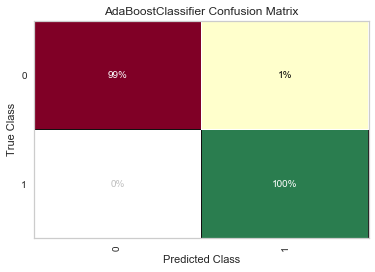

In [9]:
model = AdaBoostClassifier()
cm = ConfusionMatrix(model, percent=True)
cm.fit(oX_train, oy_train)
cm.score(oX_test, oy_test)
cm.show()

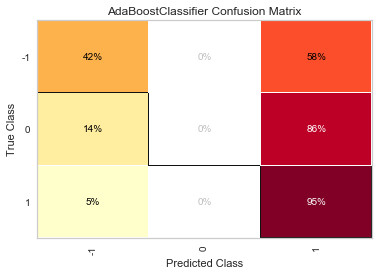

In [10]:
model = AdaBoostClassifier()
cm = ConfusionMatrix(model, percent=True)
cm.fit(gX_train, gy_train)
cm.score(gX_test, gy_test)
cm.show()

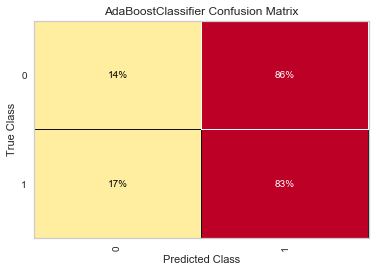

In [11]:
model = AdaBoostClassifier()
cm = ConfusionMatrix(model, percent=True)
cm.fit(rX_train, ry_train)
cm.score(rX_test, ry_test)
cm.show()